<h1>2D Ising Model: Monte Carlo Simulations</h1>
<h4>William Pugsley </h4>

In [4]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from math import sqrt, cosh, sinh, log, exp, tanh

#Thermodynamic constants
k_B = 1.380649e-23 #Units: J/K

In [5]:
#the following functions will help simplify our code throughout our simulation 


def mean(data):
    """ (list) -> (float)
    Returns the mean of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> mean(ex)
    1.5
    """
    return sum(data)/len(data)


def standard_dev(data, ave=None):
    """ (list, float/None) -> float
    Returns the standard deviation of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> standard_dev(ex)
    0.8434622525214579
    """
    if ave is None: #an average is not given and we must calculate it
        ave = mean(data) #finds the average of data
    #otherwise an average is already given as input
    
    #The following code computes the standard deviation of data
    std = 0
    for entry in data:
        std += (entry - ave)**2
        
    return sqrt(std/(len(data)-1))


def variance(data):
    """ (list) -> (float)
    """
    return standard_dev(data)**2

def standard_error(data, std=None):
    """ (list, float/None) -> (float)
    Returns the standard error of the values in data.
    
    >>> ex = [0.1, 0.4, 0.6, 0.8, 1.1, 1.2, 1.3, 1.5, 1.7, 1.9, 1.9, 2.0, 2.2, 2.6, 3.2]
    >>> standard_error(ex)
    0.21778101714468007
    """
    if std is None:
        std = standard_dev(data)
    return std/sqrt(len(data))


def normalised_residuals(x, y, fit, error):
    """ (list, list, function, list) -> (list)
    Finds the residuals of a best fit single-variable function with non-uniform error and
    returns their y-coordiantes. The error array is the standard error of the predicted values
    at each point in x.
    """
    yRes = []
    for i in range(len(x)):
        yRes.append((y[i] - fit(x[i]))/error[i])
    
    return yRes


def durbin_watson(res):
    """ (list) -> (float)
    Returns the Durbin-Watson statistic which uses the residuals to test the fit of a function.
    D=0 : systematically correlated residuals
    D=2 : randomly distributed residuals that follow a Gaussian distribution
    D=4 : systematically anticorrelated residuals
    """
    numerator = 0
    for i in range(1, len(res)):
        numerator += (res[i] - res[i-1])**2
    
    denominator = 0
    for i in range(len(res)):
        denominator += res[i]**2
    
    return numerator/denominator

<h2>Algorithm</h2>

The Monte Carlo algorithm we will use (Holmes-Cerfon 6-9) consists of creating a grid of positive and negative spins, this will be realized as a d-dimensional numpy array of +1 and -1 randomly. This algorithm will apply to any dimension d. We will iterate through each spin and calculate the energy change, $\Delta E$ associated with flipping the spin. The new state will be accepted with probability $Prob=W(\sigma',\sigma)$, where $W(\sigma',\sigma)$ satisfies the detailed balance equation (Grant 41); for our purposes this will be either the Glauber rule or the Metropolis rule. 

$W_{Metropolis}(\sigma',\sigma)=1 \; \Delta E \leq 0, \: e^{\frac{-\Delta E}{k_BT}} \; \Delta E \gt 0$

$W_{Glauber}(\sigma',\sigma)=\frac{1}{2}(1-tanh(\frac{\Delta E}{2k_BT}))$

We will do this for each spin in the strip, this is one Monte Carlo cycle. Completing N cycles for our N spins will consist of one Monte Carlo simulation (Grant 45). At the end of a simulation we can calculate the total magnetization and the magnetization per spin; with these quantities we can verify our theoretical expectation of $<m>$. Repeating for diferent temperatures should yield the temperature dependence of $<m>$. The correlation function, $<S_iS_{i+r}>$ can also be calculated from the same simulation.

<h2>2-Dimensional Ising Model</h2>

The two-dimensional Ising model consists of an NxM rectangular lattice of spin sites, $S_i$, pointing in either the positive or negative direction.

$E_{state} = -J\Sigma_{<i,j>}S_iS_j-H\Sigma S_i$

Where <i,j> denotes nearest neighbor interactions with no double counting.

We will take this time to introduce the critical exponents of the Ising model:

<h4>Setup</h4>

In [6]:
def init_grid_2d(rows, cols=None):
    """ (int, int) -> (np.array)
    Creates an 2-dimensional numpy array with rows*cols entries of randomly chosen +1 and -1 spins.
    """
    if cols is None: #square grid
        cols = rows

    grid = []
    for i in range(rows): #numer of rows
        grid.append([random.randrange(-1, 2, 2) for j in range(cols)]) 
    return np.array(grid)

def total_mag_2d(grid):
    """ (np.array) -> (int)
    Calculates the total magnetization of a 2-dimensional grid of +1/-1 spins.
    """
    tot = 0
    for row in grid:
        tot += sum(row)
    return tot

def mag_per_spin_2d(grid):
    """ (np.array) -> (float)
    Calculates the magnetization per spin of a 2-dimensional grid of +1/-1 spins.
    """
    tot = total_mag_2d(grid)
    size = len(grid)*len(grid[0]) #rows*columns
    return tot/size


def energy_2d(grid, H=0):
    """ (np.array, num) -> (num)
    Finds the total energy of a two dimensional grid with external field H using nearest neighbors interactions.
    """
    rows = len(grid) #number of rows
    cols = len(grid[0]) #nmber of columns

    E = 0 #total energy

    for row_idx in range(rows):
        for col_idx in range(cols):
            #horizontal neighbours with periodic boundary conditions
            E += grid[row_idx][col_idx]*grid[row_idx][(col_idx+1)%cols] 
            E += grid[row_idx][col_idx]*grid[row_idx][(col_idx-1)%cols]

            #vertical neighbours with periodic boundary conditions
            E += grid[row_idx][col_idx]*grid[(row_idx+1)%rows][col_idx] 
            E += grid[row_idx][col_idx]*grid[(row_idx-1)%rows][col_idx]
   
    return -E/2 - H*total_mag_2d(grid)


def print_grid_1d(grid):
    """ (np.array) -> (None)
    Prints a visulation of the one-dimensional grid given as input.
    """
    s = "|"
    for spin in grid:
        if spin == 1:
            s += " + |"
        else:
            s += " - |"
    print(s)

def print_grid_2d(grid):
    """ (np.array) -> (None)
    Prints a visulation of the 2-dimensional grid given as input.
    """
    for row in grid:
        print_grid_1d(row)

In [7]:
def energy_change_2d(grid, row_idx, col_idx, H=0):
    """ (np.array, int, int, float) -> (int)
    Calculates the energy change associated with flipping the spin at the idx position. The change is in units of J.
    H is the external field pointing in either the positive or negative direction also in units of J.
    """
    num_rows = len(grid)
    num_cols = len(grid[0])

    E = 0 #energy change

    E += 2*H*grid[row_idx][col_idx] #change due to external field
    
    #change due to horizontal neighbours with periodic boundary conditions
    E += 2*grid[row_idx][col_idx]*grid[row_idx][(col_idx+1)%num_cols] 
    E += 2*grid[row_idx][col_idx]*grid[row_idx][(col_idx-1)%num_cols]

    #change due to vertical neighbours with periodic boundary conditions
    E += 2*grid[row_idx][col_idx]*grid[(row_idx+1)%num_rows][col_idx] 
    E += 2*grid[row_idx][col_idx]*grid[(row_idx-1)%num_rows][col_idx]

    return E 



def glauber_2d(grid, row_idx, col_idx, temp, H=0):
    """ (np.array, int, int, float, float) -> (float)
    Calculates the probability that a change of state of a 2-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Glauber rule. 
    """
    energy = energy_change_2d(grid, row_idx, col_idx, H)
    return 0.5*(1 - tanh(0.5*energy/temp))


def metropolis_2d(grid, row_idx, col_idx, temp, H=0):
    """ (np.array, int, int, float, float) -> (float)
    Calculates the probability that a change of state of a 2-dimensional grid, with energy change given by energy, will occur at a given temperature, temp. The probability is calculated using the Metropolis rule. 
    """
    energy = energy_change_2d(grid, row_idx, col_idx, H)
    if energy <= 0:
        return 1
    return exp(-energy/temp)


def flip_2d(grid, row_idx, col_idx, temp, H=0, rule="metropolis"):
    """ (np.array, int, int, float, float, str) -> ()
    Flips the spin in grid at site idx with a probability given by the Metropolis or Glauber rule at temperature temp.
    """
    if rule == "glauber":
        prob = glauber_2d(grid, row_idx, col_idx, temp, H)
    elif rule == "metropolis":
        prob = metropolis_2d(grid, row_idx, col_idx, temp, H)
    else:
        raise ValueError("The rule argument take \"glauber\" or \"metropolis\" as input.")

    choice = random.uniform(0, 1)
    
    if choice <= prob: #will flip
        grid[row_idx][col_idx] *= -1
    #otherwise will not flip and nothing happens


def cycle_2d(grid, temp, H=0):
    """ (np.array, float, float) -> ()
    Will conduct one Monte Carlo cycle over grid at temperature temp. 
    """
    num_row = len(grid)
    num_col = len(grid[0])

    for row_idx in range(num_row):
        for col_idx in range(num_col):
            flip_2d(grid, row_idx, col_idx, temp, H)


def simulation_2d(grid, temp, H=0):
    """ (np.array, float, float) -> ()
    Will conduct one Monte Carlo simulation over grid at temperature temp. 
    """
    size = len(grid)*len(grid[0]) #N Monte Carlo cycles for N sites is one simulation
    for i in range(size):
        cycle_2d(grid, temp, H)

<h4>Simulation</h4>

We will create a two-dimensional numpy array of NxM sites and run a total of num_sim Monte Carlo simulations before recording the magnetization per spin. We will do this num_points times, to get that many data points, at each temperature T in temperatues. Increasing num_points will get us a more precise measurement of the magnetization per spin at different temperatures. Increasing num_sim will let our experimental results approach the long-time thermodynamic limit 

In [54]:
def full_sim_2d(rows, cols, num_points, num_sim, temperatures, H=0, output="mag"):
    """ (int, int, int, int, np.array, float) -> (list, list) or (list, list, list, list)
    rows: total number of rows
    cols: total number of columns
    num_points: number of data points at each temperature
    num_sim: total numer of simulations conducted on a strip
    temperatures: range of temperatues at which we will simulate
    H: the strength of the external field
    output: controls the value we are simulating for ("mag", "energy", or "both")
    """
    if output == "mag":
        magnetizations = [] #<m> of our simulations at various temperatues
        magnetizations_unc = [] #uncertainties in <m>

        for T in temperatures:
            m_at_t = []
            for i in range(num_points): #we do num_points simulations at each temperature for that many data points
                grid = init_grid_2d(N)
                for i in range(num_sim): #we do num_sim simulations for each grid
                    simulation_2d(grid, T, H)
                m_at_t.append(mag_per_spin_2d(grid))
            magnetizations.append(mean(m_at_t))
            magnetizations_unc.append(standard_error(m_at_t))
        return magnetizations, magnetizations_unc
    elif output == "energy":
        energies = [] #<m> of our simulations at various temperatues
        energies_unc = [] #uncertainties in <m>

        for T in temperatures:
            e_at_t = []
            for i in range(num_points): #we do num_points simulations at each temperature for that many data points
                grid = init_grid_2d(N)
                for i in range(num_sim): #we do num_sim simulations for each grid
                    simulation_2d(grid, T, H)
                e_at_t.append(energy_2d(grid))
            energies.append(mean(m_at_t))
            energies_unc.append(standard_error(m_at_t))
        return energies, energies_unc
    elif output == "both":
        energies = [] #<m> of our simulations at various temperatues
        energies_unc = [] #uncertainties in <m>
        magnetizations = [] #<m> of our simulations at various temperatues
        magnetizations_unc = [] #uncertainties in <m>
        
        for T in temperatures:
            e_at_t = []
            m_at_t = []
            for i in range(num_points): #we do num_points simulations at each temperature for that many data points
                grid = init_grid_2d(N)
                for i in range(num_sim): #we do num_sim simulations for each grid
                    simulation_2d(grid, T, H)
                e_at_t.append(energy_2d(grid))
                m_at_t.append(mag_per_spin_2d(grid))
            energies.append(mean(e_at_t))
            energies_unc.append(standard_error(e_at_t))
            magnetizations.append(mean(m_at_t))
            magnetizations_unc.append(standard_error(m_at_t))
        return energies, energies_unc, magnetizations, magnetizations_unc
    else:
        raise ValueError("The output parameter must be \"mag\", \"energy\", or \"both\".")

<h4>H=0</h4>

The H=0 case of the two-dimensional Ising model has been solved exactly for a square lattice with nearest neighbor interactions by Onsager in 1944. We will try to reproduce these results using our Monte Carlo algorithm.

In [55]:
#these values will be stored in separate variables so that we may easily change them
N = 10
num_points = 10
num_sim = 1
temperatures_h_0 = np.linspace(0.1, 3, 19) #the range of temperatures over which we will run our simulation

energies, energies_unc, magnetizations, magnetizations_unc = full_sim_2d(N, N, num_points, num_sim, temperatures_h_0, 0, "both") #run the simulation

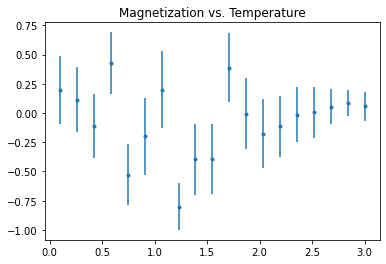

In [59]:
plt.figure()

#magnetizations_abs = [abs(x) for x in magnetizations]

plt.errorbar(x=temperatures_h_0, y=magnetizations, yerr=magnetizations_unc, marker='.', ls='', label='Simulation')

plt.title("Magnetization vs. Temperature")
plt.show()

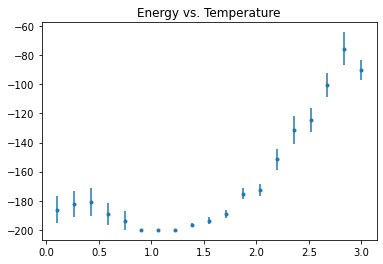

In [57]:
plt.figure()

plt.errorbar(x=temperatures_h_0, y=energies, yerr=energies_unc, marker='.', ls='', label='Simulation')

plt.title("Energy vs. Temperature")
plt.show()

<h2>Sources</h2>

* Grant, Martin. <em>Dirty tricks for statistical mechanics</em>. 2004.
    * Available here: http://www.physics.mcgill.ca/~grant/559/notes0.91.pdf
* Holmes-Cerfon, Miranda. <em>Lecture 3: Markov Chains (II): Detailed Balance, and Markov Chain Monte Carlo (MCMC)</em>. 2019.
    * Available here: https://cims.nyu.edu/~holmes/teaching/asa19/handout_Lecture3_2019.pdf
* Hott, Michael. <em>The solution of the 2D Ising model</em>. 2013. Karlsruher Institut f&#252;r Technologie, Bacelor thesis.
    * Available here: https://web.ma.utexas.edu/users/mhott/Extra%20material/bachelorthesis.pdf
* Onsager, Lars. <em>Crystal Statistics. I. A Two-Dimensional Model with an Order-Disorder Transition.</em> Physical Review, vol. 65, no. 3, 1 Feb. 1944, pp. 117–149. 
    * Available here: http://www.phys.ens.fr/~langlois/Onsager43.pdf
* Pathria, R. K., and Paul D. Beale. <em>Statistical Mechanics</em>. Elsevier, 2011. 
* Salinas S.R.A. <em>Introduction to Statistical Physics</em>. 2001. Graduate Texts in Contemporary Physics. Springer, New York, NY. https://doi.org/10.1007/978-1-4757-3508-6_13
    * Relevant chapter available here: http://www.lps.ens.fr/~krzakala/ISINGMODEL.pdf



